We would like to do regression on the Mauna Loa Atmospheric Carbon Dioxide dataset

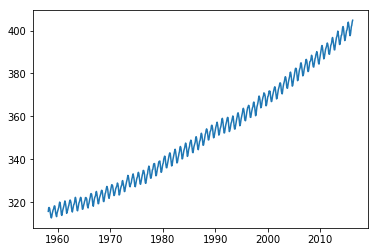

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.linalg 

#%matplotlib inline
#data = np.loadtxt('../data/motor.dat')
#X = data[:, 0][:, None]
#Y = data[:, 1]
#X_p = np.linspace(0, 60, 100)[:, None]
#fig, ax = plt.subplots()
#ax.plot(X, Y, 'x', markeredgewidth=2)
#ax.set_xlabel('$x$')
#ax.set_ylabel('$y$')

%matplotlib inline
# First download the data
import urllib
# urllib.urlretrieve('ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt', '../data/co2_mm_mlo.txt')
# Now we load it
data = np.loadtxt('co2_mm_mlo.txt')
# This is time (measured in decimal dates)
t = data[:, 2][:, None]
# This the the CO2 level (mole fraction in dry air, micromol/mol, abbreviated as ppm)
y = data[:, 4]#[:, None]
plt.plot(t, y)
X = t
Y = y
#print X
X_p = np.linspace(1958, 2026, 100)[:, None]

In [8]:
# Implementation of the basis functions
class LinearBasis(object):
    """
    Represents a 1D linear basis.
    """
    def __init__(self):
        self.num_basis = 2 # The number of basis functions
    def __call__(self, x):
        """
        ``x`` should be a 1D array.
        """
        return [1., x[0]]

In [9]:
# We need a generic function that computes the design matrix
def compute_design_matrix(X, phi):
    """
    Arguments:
    
    X   -  The observed inputs (1D array)
    phi -  The basis functions.
    """
    num_observations = X.shape[0]
    num_basis = phi.num_basis
    Phi = np.ndarray((num_observations, num_basis))
    for i in xrange(num_observations):
        Phi[i, :] = phi(X[i, :])
    return Phi

In [10]:
# Here is a class for the polynomials:
class PolynomialBasis(object):
    """
    A set of linear basis functions.
    
    Arguments:
    degree  -  The degree of the polynomial.
    """
    def __init__(self, degree):
        self.degree = degree
        self.num_basis = degree + 1
    def __call__(self, x):
        return np.array([x[0] ** i for i in range(self.degree + 1)])

In [11]:
# Here is a class for the Fourier basis:
class FourierBasis(object):
    """
    A set of linear basis functions.
    
    Arguments:
    num_terms  -  The number of Fourier terms.
    L          -  The period of the function.
    """
    def __init__(self, num_terms, L):
        self.num_terms = num_terms
        self.L = L
        self.num_basis = 2 * num_terms
    def __call__(self, x):
        res = np.ndarray((self.num_basis,))
        for i in xrange(num_terms):
            res[2 * i] = np.cos(2 * i * np.pi / self.L * x[0])
            res[2 * i + 1] = np.sin(2 * (i+1) * np.pi / self.L * x[0])
        return res

In [12]:
# Here is a class for the polynomials:
class RadialBasisFunctions(object):
    """
    A set of linear basis functions.
    
    Arguments:
    X   -  The centers of the radial basis functions.
    ell -  The assumed lengthscale.
    """
    def __init__(self, X, ell):
        self.X = X
        self.ell = ell
        self.num_basis = X.shape[0]
    def __call__(self, x):
        return np.exp(-.5 * (x - self.X) ** 2 / self.ell ** 2).flatten()

best sigma: 3.783679141168309
best alpha: [1.00000000e+00 4.36854565e-01 4.65563008e+05 5.00000961e+05
 4.99999679e+05 4.84465405e+05]


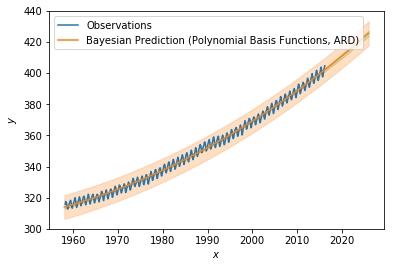

In [13]:
from sklearn.linear_model import ARDRegression
ell = .5
degree = 5
Xc = np.linspace(1958, 2016, 20)
#phi = RadialBasisFunctions(Xc, ell)
#phi = LinearBasis()
phi = PolynomialBasis(degree)
Phi = compute_design_matrix(X, phi)
regressor = ARDRegression()
regressor.fit(Phi, Y)
# They are using different names:
sigma = np.sqrt(1. / regressor.alpha_)
print 'best sigma:', sigma
alpha = regressor.lambda_
print 'best alpha:', alpha
A = np.dot(Phi.T, Phi) / sigma ** 2. + alpha * np.eye(Phi.shape[1])
L = scipy.linalg.cho_factor(A)
m = scipy.linalg.cho_solve(L, np.dot(Phi.T, Y) / sigma ** 2)  # The posterior mean of w
S = scipy.linalg.cho_solve(L, np.eye(Phi.shape[1]))           # The posterior covariance of w
Phi_p = compute_design_matrix(X_p, phi)
Y_p = np.dot(Phi_p, m) # The mean prediction
V_p_ep = np.einsum('ij,jk,ik->i', Phi_p, S, Phi_p) # The epistemic uncertainty
S_p_ep = np.sqrt(V_p_ep)
V_p = V_p_ep + sigma ** 2 # Full uncertainty
S_p = np.sqrt(V_p)
Y_l_ep = Y_p - 2. * S_p_ep  # Lower epistemic predictive bound
Y_u_ep = Y_p + 2. * S_p_ep  # Upper epistemic predictive bound
Y_l = Y_p - 2. * S_p # Lower predictive bound
Y_u = Y_p + 2. * S_p # Upper predictive bound
fig, ax = plt.subplots()
#ax.plot(X, Y, 'x', markeredgewidth=2, label='Observations')
ax.plot(X, Y, markeredgewidth=2, label='Observations')
ax.plot(X_p, Y_p, label='Bayesian Prediction (Polynomial Basis Functions, ARD)')
ax.fill_between(X_p.flatten(), Y_l_ep, Y_u_ep, color=sns.color_palette()[2], alpha=0.25)
ax.fill_between(X_p.flatten(), Y_l, Y_l_ep, color=sns.color_palette()[1], alpha=0.25)
ax.fill_between(X_p.flatten(), Y_u_ep, Y_u, color=sns.color_palette()[1], alpha=0.25)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best')

Now we want to try Gaussian Process Regression on the same data by combining a few kernels


Name : GP regression
Objective : 2391.27500516
Number of Parameters : 14
Number of Optimization Parameters : 14
Updates : True
Parameters:
  GP_regression.                            |  value  |  constraints  |  priors
  sum.rbf.variance                          |  100.0  |      +ve      |        
  sum.rbf.lengthscale                       |   50.0  |      +ve      |        
  sum.mul.periodic_exponential.variance     |    1.0  |      +ve      |        
  sum.mul.periodic_exponential.lengthscale  |    1.0  |      +ve      |        
  sum.mul.periodic_exponential.period       |    1.0  |      +ve      |        
  sum.mul.rbf.variance                      |    1.0  |      +ve      |        
  sum.mul.rbf.lengthscale                   |  100.0  |      +ve      |        
  sum.RatQuad.variance                      |    1.0  |      +ve      |        
  sum.RatQuad.lengthscale                   |    1.0  |      +ve      |        
  sum.RatQuad.power                         |    2.0  |     

 /Users/soroush/Software/miniconda2/lib/python2.7/site-packages/GPy/kern/src/periodic.py:100: RuntimeWarning:overflow encountered in divide
 /Users/soroush/Software/miniconda2/lib/python2.7/site-packages/GPy/kern/src/stationary.py:167: RuntimeWarning:overflow encountered in divide
 /Users/soroush/Software/miniconda2/lib/python2.7/site-packages/GPy/kern/src/rbf.py:43: RuntimeWarning:overflow encountered in square


Optimization restart 2/10, f = 227.948539315


 /Users/soroush/Software/miniconda2/lib/python2.7/site-packages/GPy/kern/src/rbf.py:46: RuntimeWarning:invalid value encountered in multiply
 /Users/soroush/Software/miniconda2/lib/python2.7/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/soroush/Software/miniconda2/lib/python2.7/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


Warning - optimization restart 3/10 failed
Optimization restart 4/10, f = 193.406652146
Optimization restart 5/10, f = 193.365111808


 /Users/soroush/Software/miniconda2/lib/python2.7/site-packages/GPy/kern/src/periodic.py:100: RuntimeWarning:overflow encountered in multiply


Optimization restart 6/10, f = 241.052723557
Warning - optimization restart 7/10 failed
Optimization restart 8/10, f = 202.056179458
Optimization restart 9/10, f = 217.912882364
Optimization restart 10/10, f = 268.064881818

Name : GP regression
Objective : 193.365111808
Number of Parameters : 14
Number of Optimization Parameters : 9
Updates : True
Parameters:
  GP_regression.                            |                   value  |  constraints  |  priors
  sum.rbf.variance                          |                     0.1  |   fixed +ve   |        
  sum.rbf.lengthscale                       |     0.23150266907084058  |      +ve      |        
  sum.mul.periodic_exponential.variance     |       758.2894057751946  |      +ve      |        
  sum.mul.periodic_exponential.lengthscale  |       13034.72843761082  |      +ve      |        
  sum.mul.periodic_exponential.period       |                     1.0  |   fixed +ve   |        
  sum.mul.rbf.variance                      |      1245

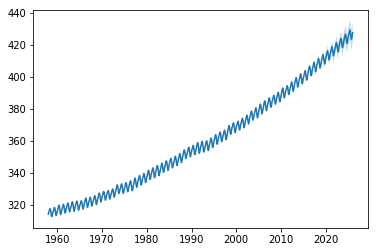

In [14]:
import cPickle as pickle
import GPy
#print X.shape
X = data[:, 2][:, None]
Y = data[:, 4][:, None]
#print Y.shape

k1 = GPy.kern.RBF(input_dim=1, variance=10**2, lengthscale=50)
k2 = GPy.kern.PeriodicExponential(input_dim=1, variance=1, lengthscale=1, period=1)*GPy.kern.RBF(input_dim=1, variance=1.**2, lengthscale=100)
k3 = GPy.kern.RatQuad(input_dim=1, variance=1.**2, lengthscale=1)
k4 = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=.1) + GPy.kern.White(input_dim=1)

k = k1 + k2 + k3 + k4

#k = k1

#k.plot()
# Construct the GP regression model
m = GPy.models.GPRegression(X, Y, k)
print m
m['.*sum.mul.periodic_exponential.period'].constrain_fixed(1.0)
m['.*sum.rbf_1.lengthscale'].constrain_fixed(50)
m['.*sum.mul.rbf.lengthscale'].constrain_fixed(100)
m['.*sum.RatQuad.lengthscale'].constrain_fixed(1)
m['.*sum.rbf.variance'].constrain_fixed(0.1)

#m.constrain_fixed('rbf_variance',0.0025)
#print m.mul.periodic_exponential.lengthscale

#m.likelihood.variance = 0
#m.optimize()
m.optimize_restarts(num_restarts=10, robust=True)
# That's it. Print some details about the model:

print m

# Now we would like to make some predictions
# Namely, we wish to predict at this dense set of points:
X_p = np.linspace(1958, 2026, 1000)[:, None]

# We can make predictions as follows
Y_p, V_p = m.predict(X_p) # Y_p = mean prediction, V_p = predictive variance
# Here is the standard deviation:
S_p = np.sqrt(V_p)
# Lower predictive bound
Y_l = Y_p - 2. * S_p
# Upper predictive bound
Y_u = Y_p + 2. * S_p

# Plot the results
fig, ax = plt.subplots()
ax.plot(X_p, Y_p, label='Predictive mean')
ax.fill_between(X_p.flatten(), Y_l.flatten(), Y_u.flatten(), alpha=0.25, label='Predictive error bars')
#ax.plot(X, Y, markeredgewidth=2, label='Observed data')

# Write the model to a file 
print '> writing model to file: surrogate.pcl'
with open('surrogate.pcl', 'wb') as fd:
    pickle.dump(m, fd)

We want to model a layered permeability field using a Gaussian Process and KLE subject to a few observations (engineers have drilled the ground and measure permeability at some points). We use ARD to maximimize the liklihood, this gives us the lenghtscales and variation for the GP kernel.

In [15]:
import numpy as np
import scipy
import GPy
import matplotlib.pyplot as plt

class KarhunenLoeveExpansion(object):
    
    """
    A class representing the Karhunen Loeve Expansion of a Gaussian random field.
    It uses the Nystrom approximation to do it.
    
    Arguments:
        k      -     The covariance function.
        Xq     -     Quadrature points for the Nystrom approximation.
        wq     -     Quadrature weights for the Nystrom approximation.
        alpha  -     The percentage of the energy of the field that you want to keep.
        X      -     Observed inputs (optional).
        Y      -     Observed field values (optional).
    """
    
    def __init__(self, k, Xq=None, wq=None, nq=100, alpha=0.9, X=None, Y=None):
        self.k = k
        if Xq is None:
            if k.input_dim == 1:
                Xq = np.linspace(0, 1, nq)[:, None]
                wq = np.ones((nq, )) / nq
            elif k.input_dim == 2:
                nq = int(np.sqrt(nq))
                x = np.linspace(0, 1, nq)
                X1, X2 = np.meshgrid(x, x)
                Xq = np.hstack([X1.flatten()[:, None], X2.flatten()[:, None]])
                wq = np.ones((nq ** 2, )) / nq ** 2
            else:
                raise NotImplementedError('For more than 2D, please supply quadrature points and weights.')
        self.Xq = Xq
        self.wq = wq
        self.k = k
        self.alpha = alpha
        self.X = X
        self.Y = Y
        # If we have some observed data, we need to use the posterior covariance
        if X is not None:
            gpr = GPy.models.GPRegression(X, Y[:, None], k)
            gpr.likelihood.variance = 1e-12
            self.gpr = gpr
            Kq = gpr.predict(Xq, full_cov=True)[1]
        else:
            Kq = k.K(Xq)
        B = np.einsum('ij,j->ij', Kq, wq)
        lam, v = scipy.linalg.eigh(B, overwrite_a=True)
        lam = lam[::-1]
        lam[lam <= 0.] = 0.
        energy = np.cumsum(lam) / np.sum(lam)
        i_end = np.arange(energy.shape[0])[energy > alpha][0] + 1
        lam = lam[:i_end]
        v = v[:, ::-1]
        v = v[:, :i_end]
        self.lam = lam
        self.sqrt_lam = np.sqrt(lam)
        self.v = v
        self.energy = energy
        self.num_xi = i_end
        
    def eval_phi(self, x):
        """
        Evaluate the eigenfunctions at x.
        """
        if self.X is not None:
            nq = self.Xq.shape[0]
            Xf = np.vstack([self.Xq, x])
            m, C = self.gpr.predict(Xf, full_cov=True)
            Kc = C[:nq, nq:].T
            self.tmp_mu = m[nq:, :].flatten()
        else:
            Kc = self.k.K(x, self.Xq)
            self.tmp_mu = 0.
        phi = np.einsum('i,ji,j,rj->ri', 1. / self.lam, self.v, self.wq, Kc)
        return phi
    
    def __call__(self, x, xi):
        """
        Evaluate the expansion at x and xi.
        """
        phi = self.eval_phi(x)
        return self.tmp_mu + np.dot(phi, xi * self.sqrt_lam)

In [16]:
import GPy
import matplotlib.cm as cm

x1_L = 356
x2_L = 670

k = GPy.kern.RBF(2, ARD=True, variance=3.2**2, lengthscale=[10./x1_L, 50./x2_L])
# k = GPy.kern.Exponential(2, ARD=True, variance=3.2**2, lengthscale=[10./x1_L, 50./x2_L])
# k = GPy.kern.Exponential(2, ARD=True, variance=3.2**2, lengthscale=[0.1*x1_L, 0.2*x2_L])

#X = np.random.rand(3, 2)
#Y = np.random.randn(3)
kle = KarhunenLoeveExpansion(k, nq=1001, alpha=0.95)#, X=X, Y=Y)
x1 = np.linspace(0, 1, 60)
x2 = np.linspace(0, 1, 220)
X1, X2 = np.meshgrid(x1, x2)
X_all = np.hstack([X1.flatten()[:, None], X2.flatten()[:, None]])
print 'Number of terms:', kle.num_xi
# Let's look at them
Phi = kle.eval_phi(X_all)
#print X1.shape
#print X2.shape
#print X_all
#print Phi
#k.plot()
print k
# for i in xrange(6):
#     fig, ax = plt.subplots()
#     c = ax.contourf(X1, X2, Phi[:, i].reshape(X1.shape), cmap=cm.jet)
    #ax.plot(X[:, 0], X[:, 1], 'rx', markeredgewidth=2)
#     plt.colorbar(c)

Number of terms: 254
  rbf.         |               value  |  constraints  |  priors
  variance     |  10.240000000000002  |      +ve      |        
  lengthscale  |                (2,)  |      +ve      |        


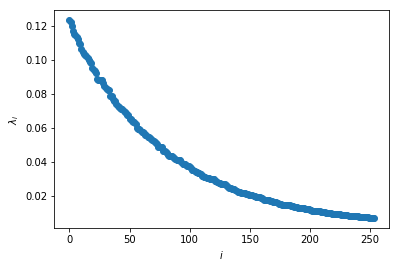

In [17]:
fig, ax = plt.subplots()
ax.plot(kle.lam, 'o')
ax.set_xlabel('$i$')
ax.set_ylabel('$\lambda_i$');

In [18]:
#x = np.linspace(0, 1, 100)[:, None]
#fig, ax = plt.subplots()
##for i in xrange(1):
#xi = np.random.randn(kle.num_xi)
#f = kle(X_all, xi)
#c = ax.contourf(X1, X2, f.reshape(X1.shape), cmap=cm.jet)
#plt.colorbar(c)
##print kle.num_xi
##print kle.X

In [19]:
#fig, ax = plt.subplots()
#c = ax.contourf(X1*x1_L, X2*x2_L, f.reshape(X1.shape), cmap=cm.jet)
#plt.colorbar(c)

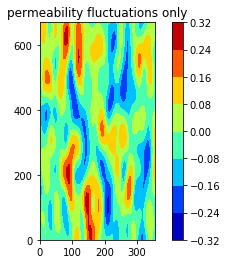

In [22]:
K = np.loadtxt('spe10_permx.dat')
x = np.linspace(0, 1, 100)[:, None]
for i in xrange(1):
    xi = np.random.randn(kle.num_xi)
    f = kle(X_all, xi)
    fig, ax = plt.subplots()
    c = plt.contourf(X1*x1_L, X2*x2_L, 0*np.log(K).T+f.reshape(X1.shape), cmap=cm.jet)
    ax.set_aspect(1.)
    ax.locator_params(nbins=4)
    plt.colorbar(c)
    plt.title('permeability fluctuations only')

In [23]:
# plt.show()
%matplotlib inline

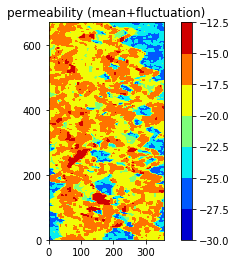

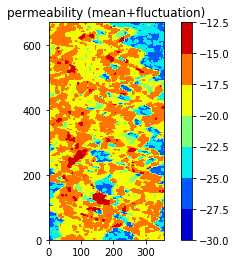

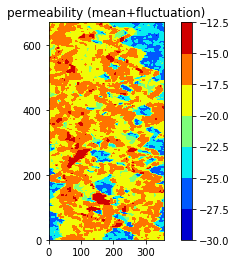

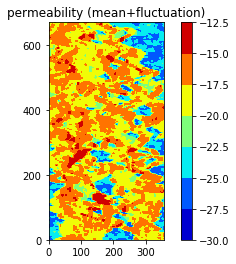

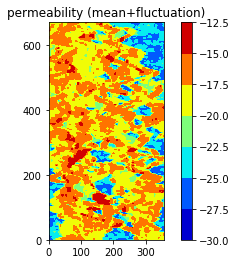

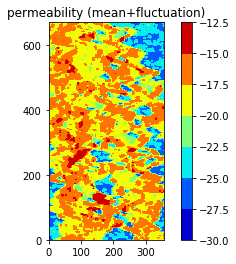

In [25]:
K = np.loadtxt('spe10_permx.dat')
x = np.linspace(0, 1, 100)[:, None]
for i in xrange(6):
    xi = np.random.randn(kle.num_xi)
    f = kle(X_all, xi)
    fig, ax = plt.subplots()
    c = plt.contourf(X1*x1_L, X2*x2_L, np.log(K).T+f.reshape(X1.shape), cmap=cm.jet)
    ax.set_aspect(1.)
    ax.locator_params(nbins=4)
    plt.colorbar(c)
    plt.title('permeability (mean+fluctuation)')

In [36]:
#import matplotlib.cm as cm
#K = np.loadtxt('../data/spe10_permx.dat')
##x1 = np.linspace(0, 356, 60)
##x2 = np.linspace(0, 670, 220)
##X1, X2 = np.meshgrid(x1, x2)
#fig, ax = plt.subplots()
#c = plt.contourf(X1*x1_L, X2*x2_L, np.log(K).T, cmap=cm.jet)
#ax.set_aspect(1.)
#ax.locator_params(nbins=4)
#plt.colorbar(c);

Now we condition the GP on some observations

In [26]:
X_obs = np.ndarray ((2 , 2)) #np.zeros((2,2))
Y_obs = np.ndarray ((2 ,)) #np.zeros((2,))
X_obs[0,0] = 100
X_obs[0,1] = 200
X_obs[1,0] = 300
X_obs[1,1] = 500
Y_obs[0] = -13.2
Y_obs[1] = -25.3
X_obs[:,0] = X_obs[:,0]/x1_L
X_obs[:,1] = X_obs[:,1]/x2_L
Y_obs = Y_obs*0
#print X_obs
#print Y_obs

Number of terms: 250
(3300,)


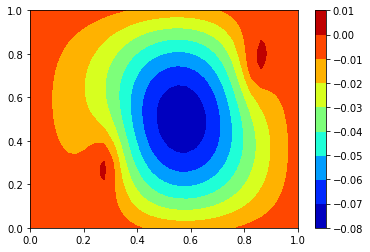

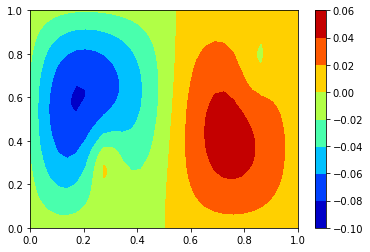

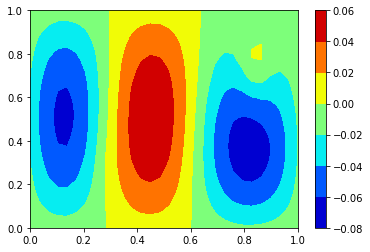

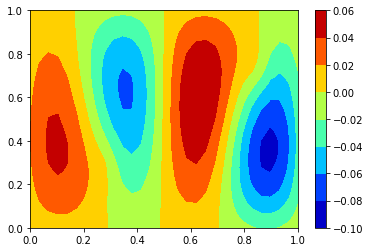

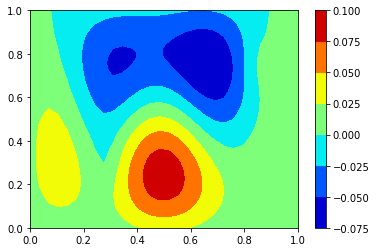

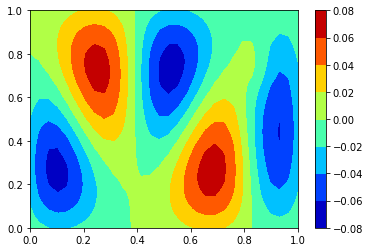

In [27]:
import GPy
import matplotlib.cm as cm

x1_L = 356.
x2_L = 670.

k = GPy.kern.RBF(2, ARD=True, variance=3.2**2, lengthscale=[10./x1_L, 50./x2_L])
#X = np.random.rand(3, 2)
#Y = np.random.randn(3)
kle = KarhunenLoeveExpansion(k, nq=900, alpha=0.95, X=X_obs, Y=Y_obs)
x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 110)
X1, X2 = np.meshgrid(x1, x2)
X_all = np.hstack([X1.flatten()[:, None], X2.flatten()[:, None]])
print 'Number of terms:', kle.num_xi
# Let's look at them
print X_all[:,0].shape

Phi = kle.eval_phi(X_all)

for i in xrange(6):
    fig, ax = plt.subplots()
    c = ax.contourf(X1, X2, Phi[:, i].reshape(X1.shape), cmap=cm.jet)
    #ax.plot(X[:, 0], X[:, 1], 'rx', markeredgewidth=2)
    plt.colorbar(c)

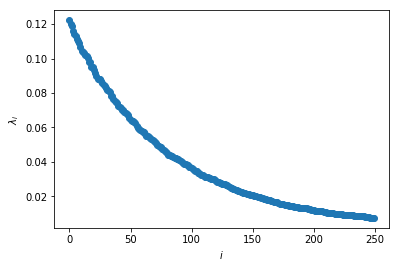

In [28]:
fig, ax = plt.subplots()
ax.plot(kle.lam, 'o')
ax.set_xlabel('$i$')
ax.set_ylabel('$\lambda_i$');

(60, 220)


 /Users/soroush/Software/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning:divide by zero encountered in log
 /Users/soroush/Software/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning:invalid value encountered in multiply


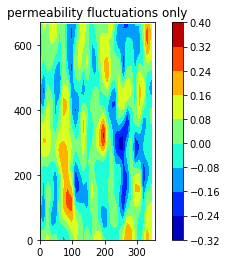

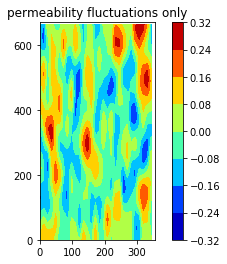

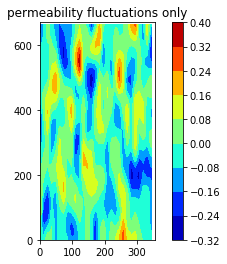

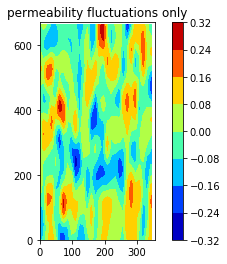

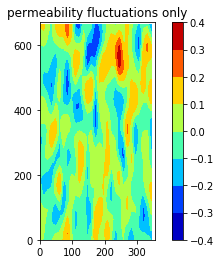

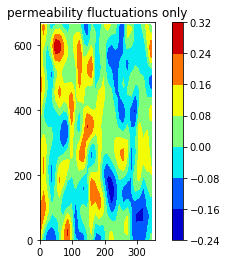

In [30]:
#np.random.seed(12345)
import matplotlib.cm as cm
K = np.loadtxt('spe10_permx.dat')
x1 = np.linspace(0, 356, 30)
x2 = np.linspace(0, 670, 110)
print K.shape
K2 = np.zeros((30,110))
for i in xrange(29):
    for j in xrange(109):
        K2[i,j] = K[2*i+1,2*j+1]           
X1, X2 = np.meshgrid(x1, x2)
#fig, ax = plt.subplots()
#c = plt.contourf(X1, X2, np.log(K2).T, cmap=cm.jet)
#ax.set_aspect(1.)
#ax.locator_params(nbins=4)
#plt.colorbar(c);

for i in xrange(6):
    xi = np.random.randn(kle.num_xi)
    f = kle(X_all, xi)
    fig, ax = plt.subplots()
    c = plt.contourf(X1, X2, 0*np.log(K2).T+1*f.reshape(X1.shape), cmap=cm.jet)
    ax.set_aspect(1.)
    ax.locator_params(nbins=4)
    plt.colorbar(c)
    plt.title('permeability fluctuations only')
#    print xi

(60, 220)


 /Users/soroush/Software/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning:divide by zero encountered in log


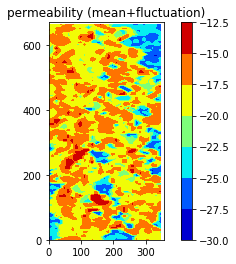

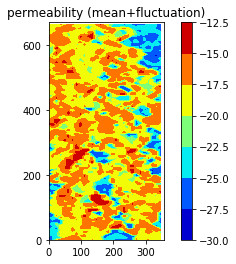

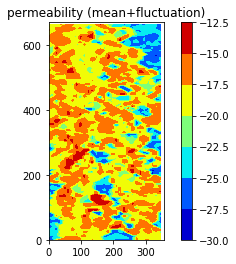

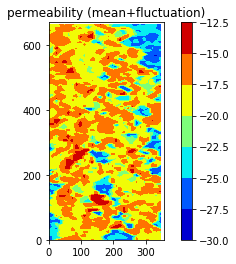

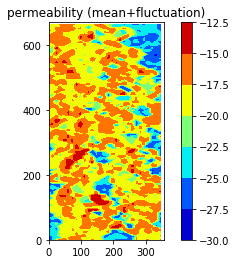

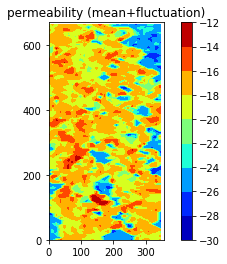

In [31]:
#np.random.seed(12345)
import matplotlib.cm as cm
K = np.loadtxt('spe10_permx.dat')
x1 = np.linspace(0, 356, 30)
x2 = np.linspace(0, 670, 110)
print K.shape
K2 = np.zeros((30,110))
for i in xrange(29):
    for j in xrange(109):
        K2[i,j] = K[2*i+1,2*j+1]           
X1, X2 = np.meshgrid(x1, x2)
#fig, ax = plt.subplots()
#c = plt.contourf(X1, X2, np.log(K2).T, cmap=cm.jet)
#ax.set_aspect(1.)
#ax.locator_params(nbins=4)
#plt.colorbar(c);

for i in xrange(6):
    xi = np.random.randn(kle.num_xi)
    f = kle(X_all, xi)
    fig, ax = plt.subplots()
    c = plt.contourf(X1, X2, 1*np.log(K2).T+1*f.reshape(X1.shape), cmap=cm.jet)
    ax.set_aspect(1.)
    ax.locator_params(nbins=4)
    plt.colorbar(c)
    plt.title('permeability (mean+fluctuation)')